## Refining our Expert Model  
### NZ Energy Demand Forecasting  

Previously, we performed a very basic exploratory analysis of the NZ Electricity Demand dataset, decided to focus on the North Island regions initially and developed baseline models.  

Our baseline models were a combination of an "expert model" which modelled a smooth demand curve throughout the year, peaking in winter and at it's lowest in the Summer. This curve was developed manually, after carefuly inspection of the data.  

To augment our expert model, we feed the expert model and historical data into our machine learning forecasting method. Our algorithm was able to balance the contribution of the expert model with historical trends and arrive at reasonably accurate forecasts.  

However, there are a couple of things to tidy up in our "expert model". First, the model was assumed to be the same for all regions, but that's not actually the case. We'll address this here, by allowing our algorithm to modify the magnitude of the demand curve for each region. Secondly, the period of the curve was a real hack-job. We're going to tidy that up here.


<br></br>  
### The Data  

You'll have already seen the data, but here is a quick recap of the North Island Regions.

In [0]:
! pip install -q arviz

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf  # essential to reset the graph and train more than one model
import tensorflow_probability as tfp
import arviz as az

tfd = tfp.distributions 
tfb = tfp.bijectors

demand = pd.read_csv("https://raw.githubusercontent.com/nickb-/nz-energy-demand-forecasting/master/data/results/north_island_baseline_forecasts.csv")
demand.date = pd.to_datetime(demand.date)

demand.head()

,ID,class,category,indicator_name,series_name,date,demand,units,TheYear,TheMonth,TheWeek,TheWeekday,TheDayOfYear,model_one_predictions,model_two_predictions
0,5773,Economic,Activity,Electricity grid demand,Upper North Island,2015-02-01,25.626,Gigawatt hours,2015,2,5,6,32,-1.820369,-1.839927
1,5774,Economic,Activity,Electricity grid demand,Upper North Island,2015-02-02,31.314,Gigawatt hours,2015,2,6,0,33,-1.338727,-1.356888
2,5775,Economic,Activity,Electricity grid demand,Upper North Island,2015-02-03,31.870,Gigawatt hours,2015,2,6,1,34,-1.245976,-1.265829
3,5776,Economic,Activity,Electricity grid demand,Upper North Island,2015-02-04,30.598,Gigawatt hours,2015,2,6,2,35,-1.248140,-1.264984
4,5777,Economic,Activity,Electricity grid demand,Upper North Island,2015-02-05,30.448,Gigawatt hours,2015,2,6,3,36,-1.242603,-1.260763


The demand is further broken down into regions:

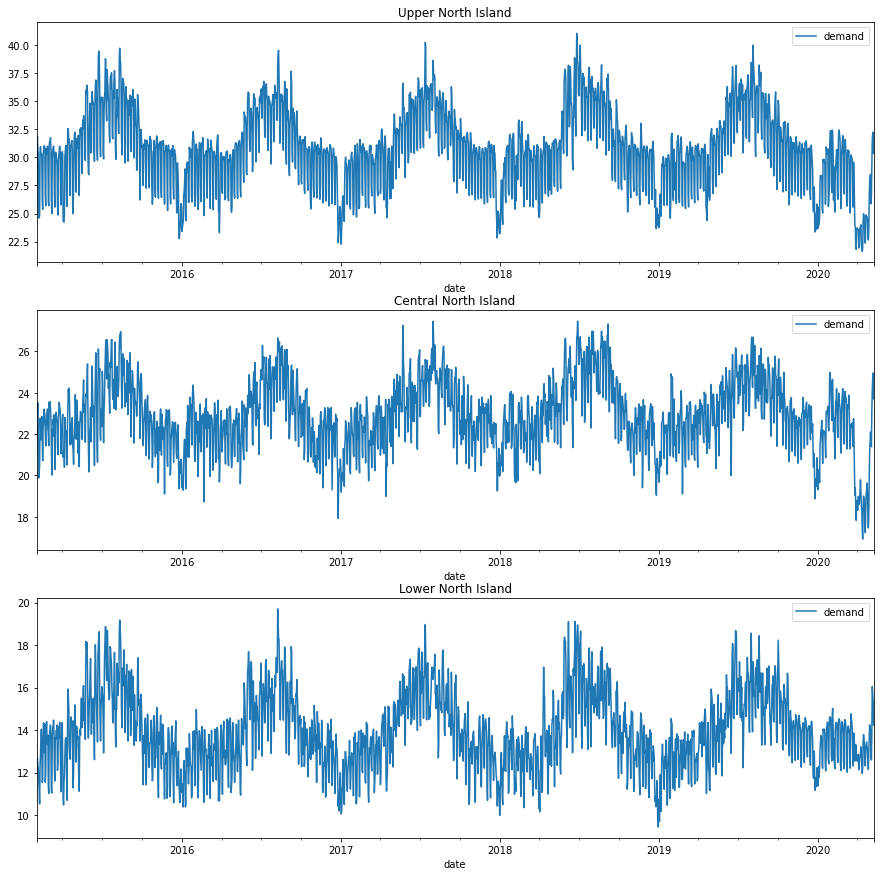

In [52]:
plt.figure(figsize=(15, 15))
for i, region in enumerate(['Upper North Island', 'Central North Island', 'Lower North Island']):
  
  demand[demand['series_name'] == region].plot(x = 'date', y = 'demand', title=region, ax = plt.subplot(3,1,i+1))
  
plt.show()

<br></br>  
### Seasonal Breakdowns  

At it's most basic, we could model the demand as a 30-day rolling average. Alternatively, we have also plotted our "expert model" below:

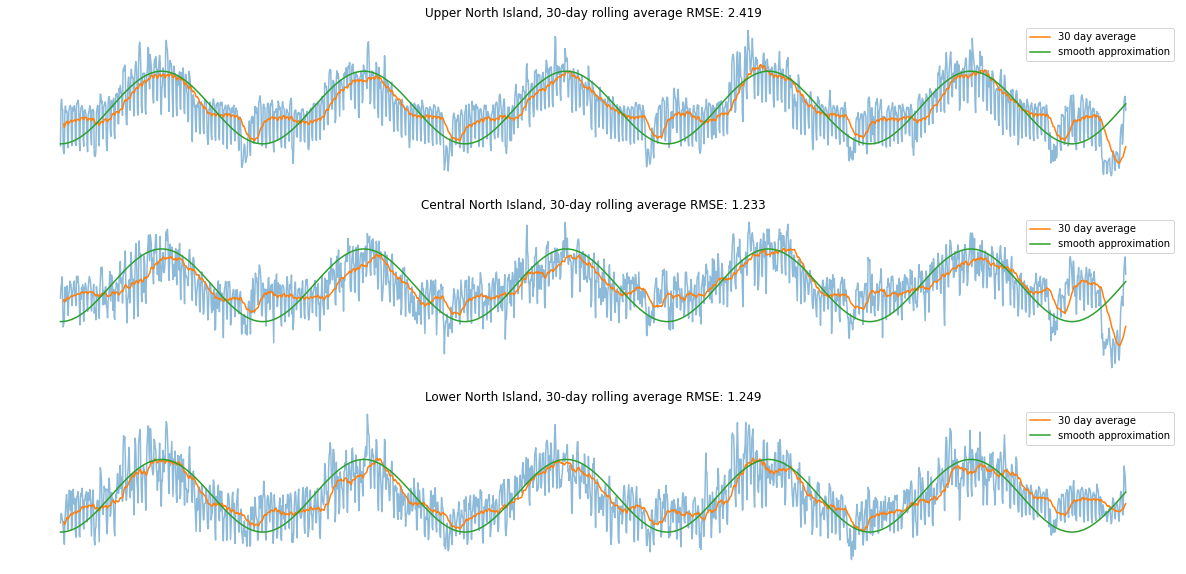

In [53]:
north = demand.query("series_name in ['Upper North Island', 'Central North Island', 'Lower North Island']")

rmse = lambda y,yhat: np.sqrt(np.mean( (y - yhat)**2 ))

plt.figure(figsize=(21,10))
for i, region in enumerate(['Upper North Island', 'Central North Island', 'Lower North Island']):

  tmp = north[north['series_name'] == region]
  rolling_average = tmp.iloc[:,6].rolling(30, min_periods=7).mean()
  
  ax = plt.subplot(3, 1 ,i+1)
  ax.plot(tmp['date'], tmp['demand'], alpha=0.5)
  ax.plot(tmp['date'],rolling_average , label='30 day average')
  ax.plot(tmp['date'], np.mean(tmp.demand) + -0.25*(np.max(tmp.demand) - np.min(tmp.demand)) * np.cos(1./18.5 * np.arange(0, tmp.shape[0]) / np.pi), label = 'smooth approximation')
  plt.title(f"{region}, 30-day rolling average RMSE: {np.round(rmse(tmp.demand, rolling_average), 3)}")
  plt.legend()
  plt.axis('off')
  
plt.show()

<br></br>  
### Improvements to our Expert Model  

We propose two major improvements here:  

**Adjust the period:**  

We will adjust the period of the curve so that it is more robust and more intuitive. Don't ask me what `(1./18.5 * t / pi)` means... it doesn't mean anything, but it looks good against the data.  

More accurately, there is clearly an annual cycle. So, we will adjust the period of the curve so that we get a complete cycle in once a year. If you remember high school geometry, the Cosine function has a period of $2\pi$, so our refined period will simply be $2\pi * t / 365$, i.e. a complete cycle over 365 days.

**Adjust the magnitude by region:**  

In magnitude of the demand curve is different in each region. So just like we have a variable intercept for each region, we will allow the model to explore a variable magnitude for each region. Very easy to add in.

In [0]:
class MonteCarloEngine:

    def __init__(self):
        self.session = None
        self.run = tf.function(
            self.sampler, autograph=False, experimental_compile=True
        )

    def reset_session(self, config = None):
        tf.reset_default_graph()

        try:
            self.session.close()
            tf.InteractiveSession.close()
        except:
            pass

        self.session = tf.InteractiveSession(config = config)

    def trace_function(self, samples, pkr):
        return (
            pkr.inner_results.inner_results.target_log_prob,
            pkr.inner_results.inner_results.leapfrogs_taken,
            pkr.inner_results.inner_results.has_divergence,
            pkr.inner_results.inner_results.energy,
            pkr.inner_results.inner_results.log_accept_ratio
        )

    def get_trace_stats(self, trace, statnames = ['log_likelihood', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']):
      return az.from_dict(sample_stats = {k:v.numpy().T for k, v in zip(statnames, trace)})

    def compare_models(self, traces = [], labels = []):
      return az.compare({
          lab:self.get_trace_stats(trace) for lab,trace in zip(labels, traces)
      })

    def sampler(
        self, 
        model = None,    # log-probability function
        nparams = None,  # number of parameters
        inits = None,    # initialisation for parameters
        trace_fn = None, # trace function
        iters = 2000,    # number of MCMC iterations
        warmup = 1000,   # warmup iterations
        chains = 1,
        bijectors_list = None
    ):
    
        if not isinstance(inits, list):
            inits = [0.01] * nparams

        # I don't understand this part yet...
        # Dig into this in the future
        if bijectors_list is None:
            bijectors_list = [tfb.Identity()] * nparams

        kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
            tfp.mcmc.TransformedTransitionKernel(
                inner_kernel=tfp.mcmc.NoUTurnSampler(
                    target_log_prob_fn = model,
                    step_size=1.0
                ),
                bijector=[tfb.Identity()] * nparams
            ),
            target_accept_prob=.8,
            num_adaptation_steps=np.floor(0.5*warmup),
            step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
                    inner_results=pkr.inner_results._replace(step_size=new_step_size)
                ),
            step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
            log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
        )

        samples, trace = tfp.mcmc.sample_chain(
            num_results = iters,
            num_burnin_steps = warmup,
            current_state = inits,
            kernel = kernel,
            trace_fn = trace_fn
        )

        return [samples, trace]

mcmc_engine = MonteCarloEngine()

Our model will be very similar to before, with the one addition of a hierarchical term for the magnitude of the cosine curve. For those who like the maths:


$$
demand \sim Normal(\mu, \sigma)  \\    
\mu_{i} = \alpha + \beta_{1,region_i} + \beta_{2,month_i} + \beta_{3,day_i} + \beta_{4,region_i} * expert_i + \epsilon  \\  
\alpha \sim Normal(0, 1) \\  
\beta_4 \sim Normal(0, \gamma_{1,2,3}) \\  
\beta_{1,2,3} \sim Normal(0, \tau_{1,2,3})  \\  
\gamma_{1,2,3} \sim HalfCauchy(0, 1)  \\  
\tau_{1,2,3} \sim HalfCauchy(0, 1)  \\  
\sigma \sim HalfCauchy(0, 1)
$$  

In [34]:
mcmc_engine.reset_session()

# Prepare the data

#### Expert model period: a complete cycle over 365 days
timesteps = north[north['series_name'] == 'Upper North Island'].shape[0]
expert_series = np.cos(2. * np.pi * np.arange(timesteps, dtype=np.float32) / 365.)

#### Model Data
[daily_demand, region, month, day, expert_index] = [
    tf.cast((north.demand - 23.), dtype=tf.float32),        # roughly centered
    tf.cast([0 if x == 'Lower North Island' else 1 if x == 'Central North Island' else 2 for x in north.series_name.values], dtype=tf.int32),
    tf.cast(north.TheMonth - 1, dtype=tf.int32),            # zero-indexed
    tf.cast(north.TheWeekday, dtype=tf.int32),

    # Expert model
    tf.cast(np.concatenate([expert_series]*3), dtype=tf.float32)
]

# Define the model
demand_model = tfd.JointDistributionSequential(
    [
        # global mean and variance
        tfd.Normal(loc=0., scale=1., name='global_mean'),
        tfd.HalfCauchy(0.0, 1.0, name='sigma'),
     
        # Hierarchical scale and intercepts for the regions  
        tfd.HalfCauchy(0.0, 1.0, name='var_region'),
        lambda var_region: tfd.Sample(tfd.Normal(loc=0.0, scale=var_region, name='rv_region'), sample_shape=3),    # There are 3 regions  
     
        # Hierarchical scale and intercepts for the month  
        tfd.HalfCauchy(0.0, 1.0, name = 'var_month'), 
        lambda var_month: tfd.Sample(tfd.Normal(loc=0.0, scale=var_month, name='rv_month'), sample_shape=12),      # 12 months a year
     
        # Hierarchical scale and intercept for the day  
        tfd.HalfCauchy(0.0, 1.0, name='var_day'), 
        lambda var_day: tfd.Sample(tfd.Normal(loc=0.0, scale=var_day, name='rv_day'), sample_shape=7),             # 7 days a week
     
        # Expert effects 
        # MAGNITUDE: hierarchical by region
        tfd.HalfCauchy(0.0, 1.0, name='var_expert_magnitude'),
        lambda var_expert_magnitude: tfd.Sample(
            tfd.Normal(loc = -1.0, scale=var_expert_magnitude, name='rv_expert_magnitude'), 
            sample_shape=3
        ),
     
        # PERIOD: constant across all regions
        # I've removed this from the model, the period is 365 days, 
        # there can be no argument with that.
     
        # Demand  
        lambda rv_expert_magnitude, var_expert_magnitude, rv_day, var_day, rv_month, var_month, rv_region, var_region, sigma, global_mean: 
            tfd.Independent(
                tfd.Normal(
                    loc = global_mean + 
                          tf.gather(rv_expert_magnitude, region, axis=-1) * expert_index +
                          tf.gather(rv_region, region, axis=-1) +
                          tf.gather(rv_month, month, axis=-1) +
                          tf.gather(rv_day, day, axis=-1),
                    scale = sigma
                ), reinterpreted_batch_ndims=1
            )
    ]
)
def demand_jd_likelihood(*args):
  return demand_model.log_prob(*args + (daily_demand, ))

priors = demand_model.sample()
samples, trace_ = mcmc_engine.run(
    model = demand_jd_likelihood,
    nparams = len(priors) - 1,
    inits = priors[:-1],
    chains=2,
    iters = 2500,
    warmup = 1000,
    trace_fn = mcmc_engine.trace_function
)
samples

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[<tf.Tensor: shape=(2500,), dtype=float32, numpy=
 array([-0.6831996 , -0.62239194, -0.68559927, ..., -0.75314903,
         1.0681095 , -0.3165931 ], dtype=float32)>,
 <tf.Tensor: shape=(2500,), dtype=float32, numpy=
 array([1.350367 , 1.3662726, 1.3654513, ..., 1.3717952, 1.373876 ,
        1.3956345], dtype=float32)>,
 <tf.Tensor: shape=(2500,), dtype=float32, numpy=
 array([9.20221  , 9.106974 , 9.075879 , ..., 5.4346695, 6.8482   ,
        3.707416 ], dtype=float32)>,
 <tf.Tensor: shape=(2500, 3), dtype=float32, numpy=
 array([[ -8.152219  ,   0.7395587 ,   8.632698  ],
        [ -8.715132  ,   0.18809202,   8.084963  ],
        [ -8.738195  ,   0.22956337,   8.175502  ],
        ...,
        [ -7.980097  ,   0.94476324,   8.922111  ],
        [-10.014922  ,  -1.0985762 ,   6.8179374 ],
        [ -9.304421  ,  -0.3591572 ,   7.5513926 ]], dtype=float32)>,
 <tf.Tensor: shape=(2500,), dtype=float32, numpy=
 array([0.64390856, 0.52665484, 0.6275232 , ..., 0.81544924, 0.49431944,
     

As for our baseline models, we'll carefully inspect our posteriors.

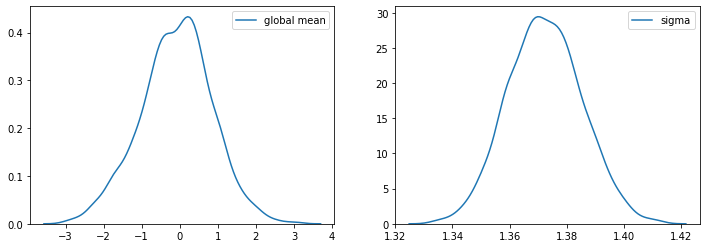

In [35]:
plt.figure(figsize=(12,4))
for i, (label, z) in enumerate(zip(['global mean', 'sigma'], samples[:2])):

  ax = plt.subplot(1, 2, i+1)
  sns.kdeplot(z.numpy(), label=label, ax=ax)
  plt.legend(loc="upper right")

plt.show()

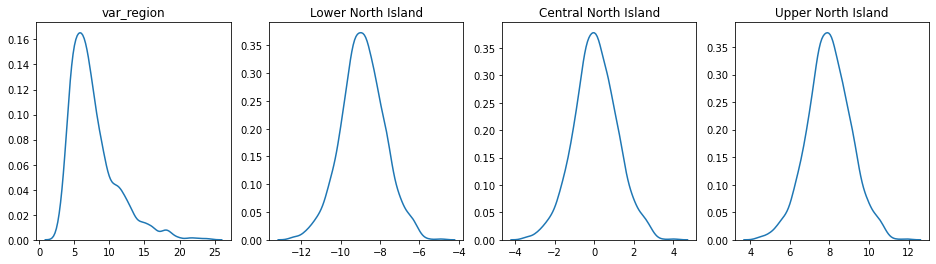

In [36]:
region_labels = ['var_region', 'Lower North Island', 'Central North Island', 'Upper North Island']
region_posteriors = [samples[2].numpy()] + [samples[3].numpy()[:,i] for i in range(3)]

plt.figure(figsize=(16,4))
for i, (label, z) in enumerate(zip(region_labels, region_posteriors)):

  ax = plt.subplot(1, 4, i+1)
  sns.kdeplot(z, ax=ax)
  plt.title(label)

plt.show()

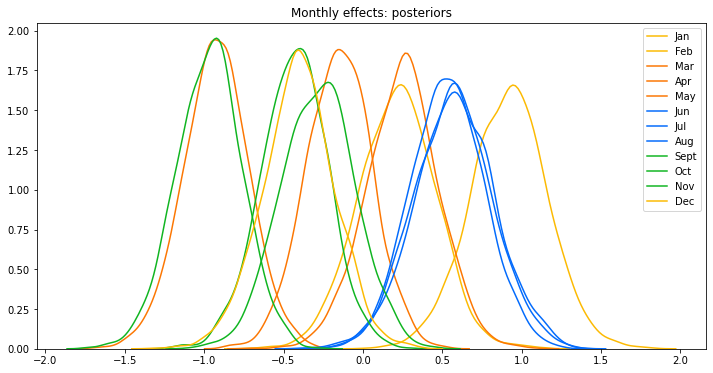

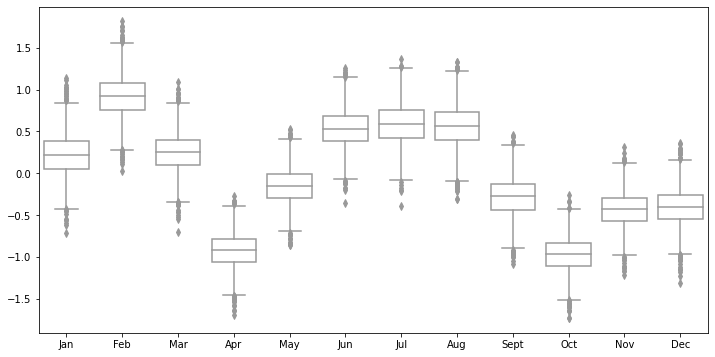

In [37]:
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
month_posteriors = [samples[5].numpy()[:,i] for i in range(12)]
colours = ['#fcba03', '#fcba03', '#fc7703', '#fc7703', '#fc7703',
           '#036bfc', '#036bfc', '#036bfc', '#10b521', '#10b521', '#10b521','#fcba03'] 

plt.figure(figsize=(12,6))
for i, (label, z, colour) in enumerate(zip(month_labels, month_posteriors, colours)):
  
  sns.kdeplot(z, label=label, color=colour)

plt.title("Monthly effects: posteriors")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x=month_labels, y=month_posteriors, color='white')
plt.show()

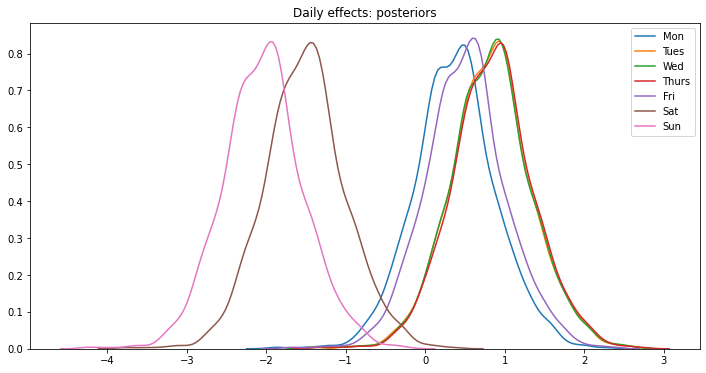

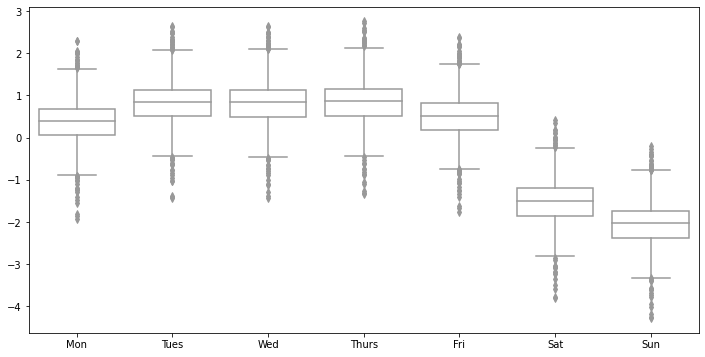

In [38]:
day_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
day_posteriors = [samples[7].numpy()[:,i] for i in range(7)]

plt.figure(figsize=(12,6))
for i, (label, z) in enumerate(zip(day_labels, day_posteriors)):
  
  sns.kdeplot(z, label=label)

plt.title("Daily effects: posteriors")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x=day_labels, y=day_posteriors, color='white')
plt.show()

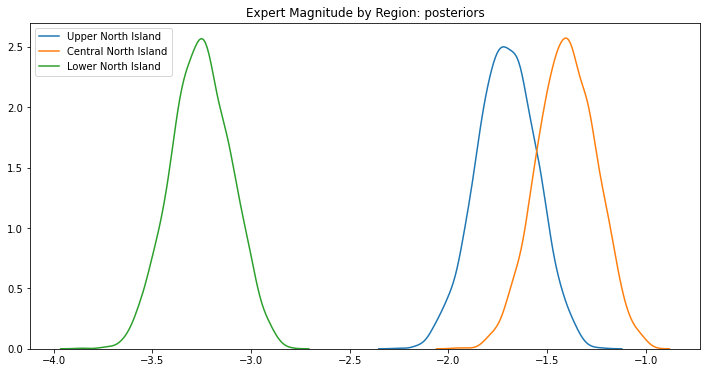

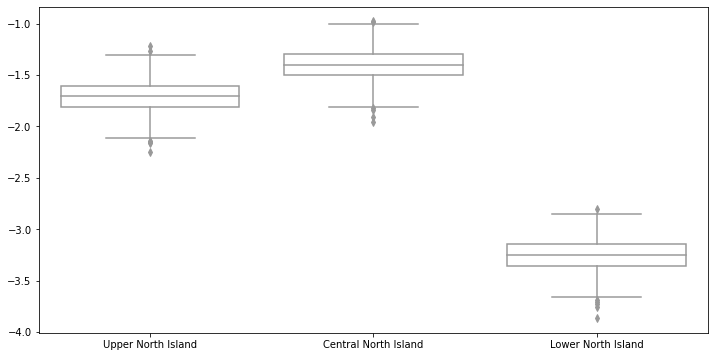

In [39]:
region_labels = ['Upper North Island', 'Central North Island', 'Lower North Island']
region_expert_posteriors = [samples[9].numpy()[:,i] for i in range(3)]

plt.figure(figsize=(12,6))
for i, (label, z) in enumerate(zip(region_labels, region_expert_posteriors)):
  
  sns.kdeplot(z, label=label)

plt.title("Expert Magnitude by Region: posteriors")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x=region_labels, y=region_expert_posteriors, color='white')
plt.show()

# sns.kdeplot(samples[10].numpy(), label='rv_expert_period')

#### Model One: predictions  

Now, let's look at our predictions. These are in-sample predictions, but I am happy with that - we are looking at how well we capture the "data generating process" for now, and there is *no way* that we've overfit the data at this point.

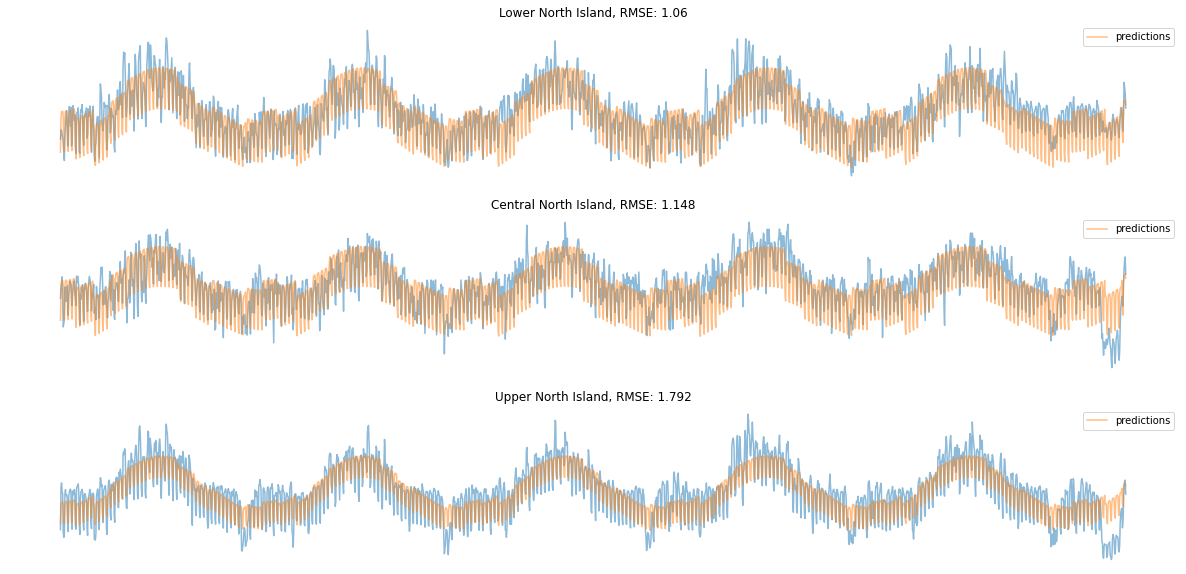

In [40]:
def predict(data):
  region, month, day, expert_index = data
  alpha = samples[0].numpy()
  rv_expert_magnitude = samples[9].numpy()
  rv_region = samples[3].numpy()
  rv_month = samples[5].numpy()
  rv_day = samples[7].numpy()

  expert_ = alpha +  rv_expert_magnitude[:, region] * expert_index

  return np.mean(alpha + expert_ + rv_region[:, region] + rv_month[:, month] + rv_day[:, day])

def rmse(y, yhat):  
  return np.sqrt(np.mean( (y - yhat)**2 ))

predictions = np.array([])
plt.figure(figsize=(21,10))
for i, region in enumerate(['Lower North Island', 'Central North Island', 'Upper North Island']):

  tmp = north[north['series_name'] == region]
  yhats = np.array([predict([i, tmp.TheMonth.values[x]-1, tmp.TheWeekday.values[x], expert_series[x]]) for x in range(tmp.shape[0])])
  predictions = np.concatenate([predictions, yhats])
  
  ax = plt.subplot(3, 1 ,i+1)
  ax.plot(tmp['date'], tmp['demand'], alpha=0.5)
  ax.plot(tmp['date'], yhats + 23., label = 'predictions', alpha=0.5)
  plt.title(f"{region}, RMSE: {np.round(rmse(tmp.demand, yhats + 23.), 3)}")
  plt.legend()
  plt.axis('off')
  
plt.show()

north['expert_one_predictions'] = predictions

Fantastic, these are a good improvement already. The forecasts for each region rise and fall nicely within the range of historical data. Our accuracy is improved over the baseline as a result.


<br></br>
### Model Two: Variable variance  

The above mode looks really good. But there is quite a descrepancy between the scale of the Upper North Island compared to the other two regions. So I am going to explore adding a regional scale parameter to the demand forecasts. 

(I won't repeat the maths here, we are just going to have 3 scale parameters for demand.)

In [42]:
mcmc_engine.reset_session()

# Prepare the data
[daily_demand, region, month, day, expert_index] = [
    tf.cast((north.demand - 23.), dtype=tf.float32),        # roughly centered
    tf.cast([0 if x == 'Lower North Island' else 1 if x == 'Central North Island' else 2 for x in north.series_name.values], dtype=tf.int32),
    tf.cast(north.TheMonth - 1, dtype=tf.int32),            # zero-indexed
    tf.cast(north.TheWeekday, dtype=tf.int32),

    # Expert model
    # This is now a time index 1..t in days 
    tf.cast(np.concatenate([expert_series]*3), dtype=tf.float32)
]

# Define the model
demand_model = tfd.JointDistributionSequential(
    [
        # global mean and variance
        tfd.Normal(loc=0., scale=1., name='global_mean'),
        tfd.Sample(tfd.HalfCauchy(0.0, 1.0, name='sigma'), sample_shape=3), # variable variance per region  
     
        # Hierarchical scale and intercepts for the regions  
        tfd.HalfCauchy(0.0, 1.0, name='var_region'),
        lambda var_region: tfd.Sample(tfd.Normal(loc=0.0, scale=var_region, name='rv_region'), sample_shape=3),    # There are 3 regions  
     
        # Hierarchical scale and intercepts for the month  
        tfd.HalfCauchy(0.0, 1.0, name = 'var_month'), 
        lambda var_month: tfd.Sample(tfd.Normal(loc=0.0, scale=var_month, name='rv_month'), sample_shape=12),      # 12 months a year
     
        # Hierarchical scale and intercept for the day  
        tfd.HalfCauchy(0.0, 1.0, name='var_day'), 
        lambda var_day: tfd.Sample(tfd.Normal(loc=0.0, scale=var_day, name='rv_day'), sample_shape=7),             # 7 days a week
     
        # Expert effects 
        # MAGNITUDE: hierarchical by region
        tfd.HalfCauchy(0.0, 1.0, name='var_expert_magnitude'),
        lambda var_expert_magnitude: tfd.Sample(
            tfd.Normal(loc = -1.0, scale=var_expert_magnitude, name='rv_expert_magnitude'), 
            sample_shape=3
        ),
     
        # PERIOD: constant across all regions
        # I've removed this from the model, the period is 365 days, 
        # there can be no argument with that.
     
        # Demand  
        lambda rv_expert_magnitude, var_expert_magnitude, rv_day, var_day, rv_month, var_month, rv_region, var_region, sigma, global_mean: 
            tfd.Independent(
                tfd.Normal(
                    loc = global_mean + 
                          tf.gather(rv_expert_magnitude, region, axis=-1) * expert_index +
                          tf.gather(rv_region, region, axis=-1) +
                          tf.gather(rv_month, month, axis=-1) +
                          tf.gather(rv_day, day, axis=-1),
                    scale = tf.gather(sigma, region, axis=-1)
                ), reinterpreted_batch_ndims=1
            )
    ]
)
def demand_jd_likelihood(*args):
  return demand_model.log_prob(*args + (daily_demand, ))

priors = demand_model.sample()
samples, trace_ = mcmc_engine.run(
    model = demand_jd_likelihood,
    nparams = len(priors) - 1,
    inits = priors[:-1],
    chains=2,
    iters = 2500,
    warmup = 1000,
    trace_fn = mcmc_engine.trace_function
)
samples

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[<tf.Tensor: shape=(2500,), dtype=float32, numpy=
 array([-0.48742652, -0.29933187,  0.17643592, ..., -1.3451937 ,
        -1.3292209 ,  0.18897702], dtype=float32)>,
 <tf.Tensor: shape=(2500, 3), dtype=float32, numpy=
 array([[0.98623854, 1.0944062 , 1.932772  ],
        [0.9715572 , 1.0843947 , 1.9097604 ],
        [0.97818637, 1.0332067 , 1.9720279 ],
        ...,
        [0.99809515, 1.0837592 , 1.9377921 ],
        [1.0053201 , 1.089423  , 1.9349023 ],
        [0.96143204, 1.070363  , 1.9537995 ]], dtype=float32)>,
 <tf.Tensor: shape=(2500,), dtype=float32, numpy=
 array([10.045647 ,  8.156999 ,  4.7961593, ...,  7.0800967,  7.11378  ,
         3.6403973], dtype=float32)>,
 <tf.Tensor: shape=(2500, 3), dtype=float32, numpy=
 array([[-8.2268000e+00,  7.0144814e-01,  8.7287436e+00],
        [-8.2379761e+00,  6.7737073e-01,  8.6543045e+00],
        [-9.9940748e+00, -1.0626848e+00,  6.8390303e+00],
        ...,
        [-8.9498653e+00, -1.3539489e-02,  7.9248538e+00],
        [-8.9518

Again, a good look at the posteriors:

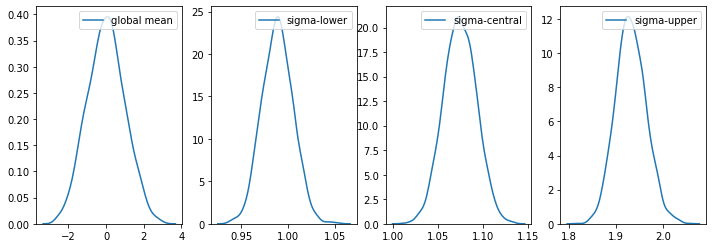

In [43]:
plt.figure(figsize=(12,4))
for i, (label, z) in enumerate(zip(['global mean', 'sigma-lower', 'sigma-central', 'sigma-upper'], [samples[0]] + [samples[1][:,i] for i in range(3)])):

  ax = plt.subplot(1, 4, i+1)
  sns.kdeplot(z.numpy(), label=label, ax=ax)
  plt.legend(loc="upper right")

plt.show()

This confirms my suspicion, that there is quite a difference in the variance between regions. The Upper North Island is nearly twice as large as the other two. 

This should give us tighter, more confident forecasts for the Central and Lower North Island, though will increase the uncertainty in the Upper North Island.This might feel like a backwards step for the Upper North Island, but it is important that we accurately capture the uncertainty in our forecasts and calibrate them appropriately - otherwise any decisions we make will be at risk of being too optimistic.


All of the other posteriors remain relatively unchanged, so we won't repeat these plots here.

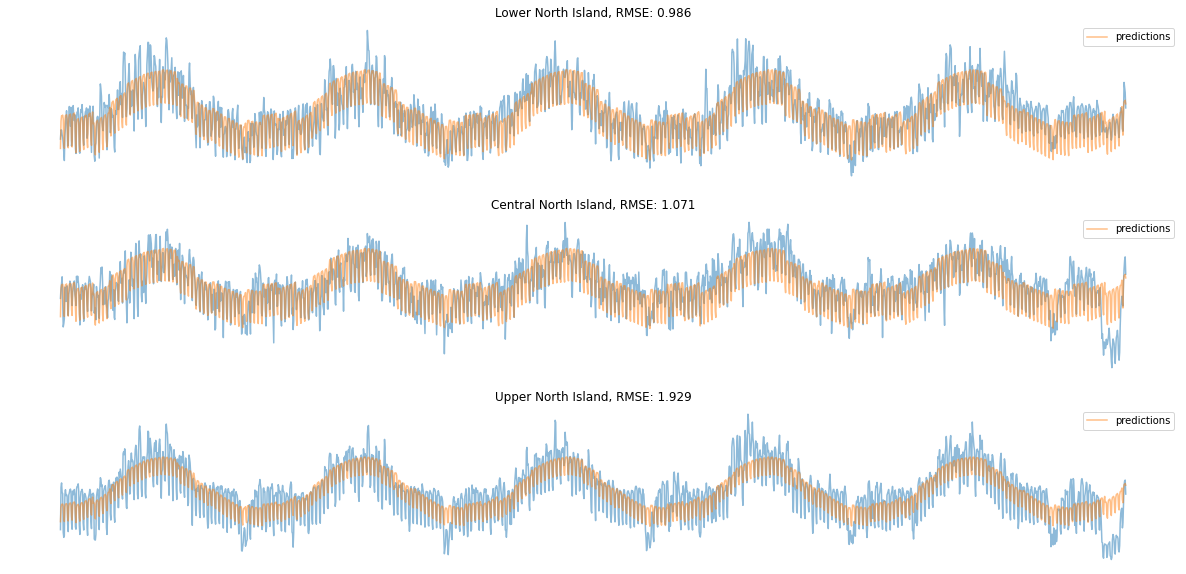

In [71]:
def predict(data):
  region, month, day, expert_index = data
  alpha = samples[0].numpy()
  rv_expert_magnitude = samples[9].numpy()
  rv_region = samples[3].numpy()
  rv_month = samples[5].numpy()
  rv_day = samples[7].numpy()
  sigma = samples[1]

  mu = alpha + rv_expert_magnitude[:, region] * expert_index + rv_region[:, region] + rv_month[:, month] + rv_day[:, day]
  z = np.random.normal(np.mean(mu), np.mean(sigma[:,region]), size=1000)
  return np.mean(mu)

def rmse(y, yhat):  
  return np.sqrt(np.mean( (y - yhat)**2 ))

predictions = np.array([])
plt.figure(figsize=(21,10))
for i, region in enumerate(['Lower North Island', 'Central North Island', 'Upper North Island']):

  tmp = north[north['series_name'] == region]
  yhats = np.array([predict([i, tmp.TheMonth.values[x]-1, tmp.TheWeekday.values[x], expert_series[x]]) for x in range(tmp.shape[0])])
  predictions = np.concatenate([predictions, yhats])
  
  ax = plt.subplot(3, 1 ,i+1)
  ax.plot(tmp['date'], tmp['demand'], alpha=0.5)
  ax.plot(tmp['date'], yhats + 23., label = 'predictions', alpha=0.5)
  plt.title(f"{region}, RMSE: {np.round(rmse(tmp.demand, yhats + 23.), 3)}")
  plt.legend()
  plt.axis('off')
  
plt.show()

north['expert_two_predictions'] = predictions

This is very positive. We have substantial improvements in the accuracy of the Lower and Central North Island. The accuracy of the Upper North Island has lowered, but remember we have only plotted the mean estiamtes here, they would be a lot more interesting if we were to also look at the credible intervals, so let's do that.

#### Forecasts with uncertainty  

For this, we will plot the last 2 years (simply for visual clarity)

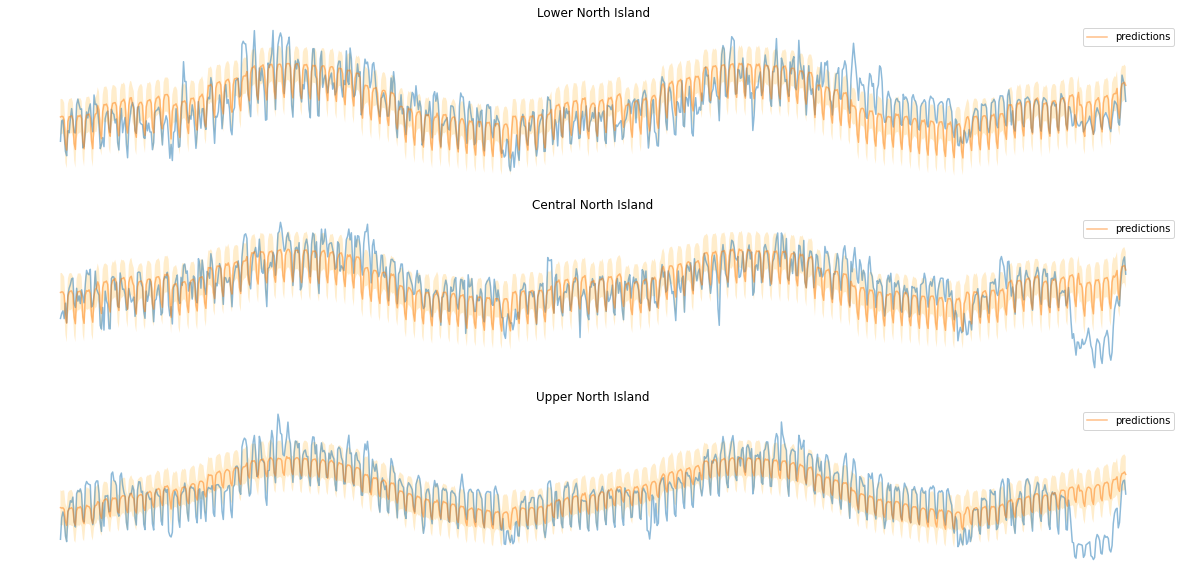

In [85]:
def predict(data):
  region, month, day, expert_index = data
  alpha = samples[0].numpy()
  rv_expert_magnitude = samples[9].numpy()
  rv_region = samples[3].numpy()
  rv_month = samples[5].numpy()
  rv_day = samples[7].numpy()
  sigma = samples[1]

  mu = alpha + rv_expert_magnitude[:, region] * expert_index + rv_region[:, region] + rv_month[:, month] + rv_day[:, day]
  z = np.random.normal(np.mean(mu), np.mean(sigma[:,region]), size=1000)
  return np.quantile(z, 0.11), np.mean(z), np.quantile(z, 0.89)


plt.figure(figsize=(21,10))
for i, region in enumerate(['Lower North Island', 'Central North Island', 'Upper North Island']):

  tmp = north[north['series_name'] == region]
  tmp = tmp[tmp['date'] > '2018-01-01']
  tmp.reset_index()

  results = np.array([predict([i, tmp.TheMonth.values[x]-1, tmp.TheWeekday.values[x], expert_series[x]]) for x in range(tmp.shape[0])])
  predictions = np.concatenate([predictions, results[:,1]])
  
  ax = plt.subplot(3, 1 ,i+1)
  ax.plot(tmp['date'], tmp['demand'], alpha=0.5)
  ax.plot(tmp['date'], results[:,1] + 23., label = 'predictions', alpha=0.5)
  ax.fill_between(tmp['date'], results[:,0] + 23., results[:,2] + 23., facecolor='orange', alpha=0.2)
  plt.title(f"{region}")
  plt.legend()
  plt.axis('off')
  
plt.show()

### Criticisms and Future Work  

These forecasts are starting to look really, really good. There are a couple more areas to address.  

**Holiday Effects**  
This is quite obvious in the forecast visualisation with all 5 years of data. We can see the impact the Christmas and New Year has on demand, and we need to factor this in.  

**Spring and Autumn**  
When we start to zoom in on the data (see the last 2 years visualised above), we can see another problem with our smooth expert model:   

  - the demand has been overestimated for Autumn months in the Upper North Island.  
  - the demand might be slightly underestimated for Sprin in the Lower North Island. 

This suggests that the cyclic nature of demand isn't the same across all regions and it may need refining from one region to the next. There's an intuitive explanation for this:  

  - if demand is related to the weather (spiking during the coldest months), then differences in the weather across each region will drive subtly different demand curves  
  - this makes sense as to why we might be overestimating Autumn in the Upper North Island, which is more likely to be warmer than the lower regions and therefore, not have such a high demand which relates to heating  
  - equally, if Spring colder in the Lower North Island than the other two regions, their demand will probably be a little higher than the other two.  

So, we need to think about this and factor in these subtle seasonal differences between regions. This will be our next step.  

**The Lockdown-Effect**  

Finally, the massive dropoff durign hte COVID-19 lockdown is obvious and it just doesn't fit the model. There are a few ways we could deal with this:  

  - we could fit a custom model for the lockdown period  
  - we could ignore it. It is a relatively short period and we are already back to normal. Many forecasting and machine learning efforts are simply ignoring the exceptional impact of COVID-19  
  - or (and this is my favourite), it is possibly just a special case of the holiday effect. So perhaps we could accurately model is accordingly. We will certainly be giving this a go.  

In [0]:
north.to_csv("./north_island_baseline_forecasts.csv", index=None)

In [0]:
# Last, I am going to download the results for future reference
from google.colab import files
files.download("./north_island_baseline_forecasts.csv")